The following code snippet reproduces the pre and post calibration results of random forest classifier using fluorescence data.

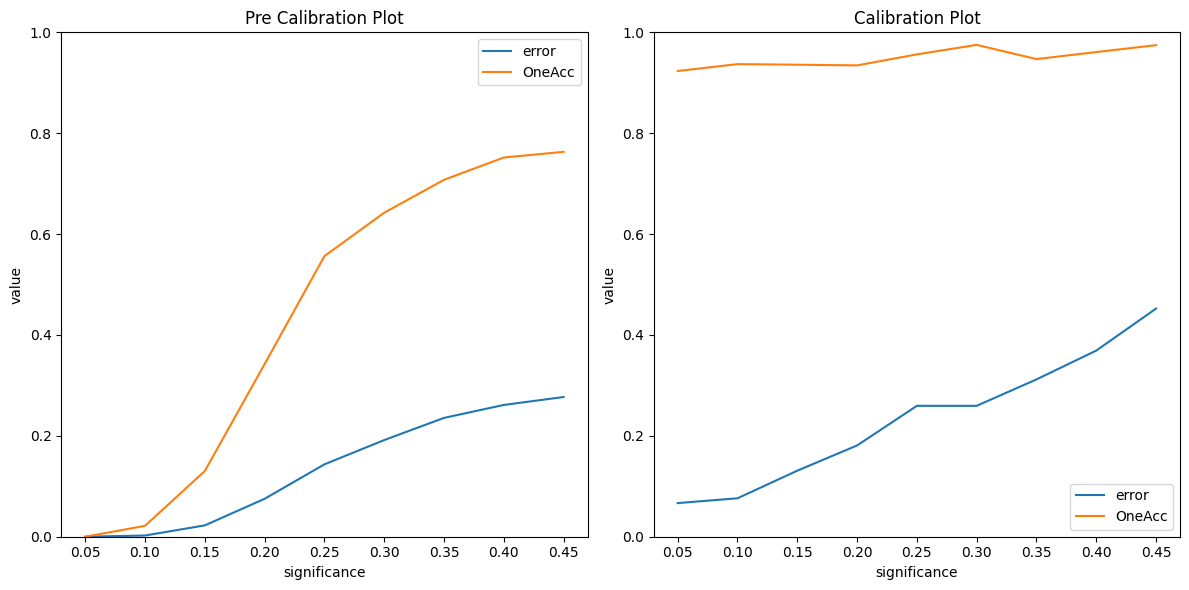

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from numpy import genfromtxt

def comp_margin(s, l):
    m, p = s.shape
    indx = np.zeros((m, p))
    indx[np.arange(m), l] = 1

    data_other_class = np.ma.array(s, mask=indx)
    data_true_class = np.ma.array(s, mask=~data_other_class.mask)

    s_other = data_other_class.compressed().reshape((m, p - 1))
    s_true = data_true_class.compressed().reshape((m, 1))

    margin = s_true - np.max(s_other, axis=1, keepdims=True)
    return margin

def nc_margin(s_cal, s_val, l):
    m_cal = comp_margin(s_cal, l)
    m_val = np.empty(s_val.shape)
    for j in range(s_val.shape[1]):
        m_val[:, j] = comp_margin(s_val, np.ones(s_val.shape[0], dtype=np.int8) * j).flatten()
    return m_cal, m_val

def calibrate_scores(smx, labels, alphas, n_calib=200, MARGIN=True, n_run=5):
    if smx.ndim == 3:
        errors_list = []
        accs_list = []
        n_models = smx.shape[2]
        for j in range(n_models):
            err_j, acc_j = calibrate_scores(smx[:, :, j], labels, alphas, n_calib, MARGIN, n_run)
            errors_list.append(err_j)
            accs_list.append(acc_j)
        errors = np.mean(errors_list, axis=0)
        accs = np.mean(accs_list, axis=0)
        return errors, accs

    errors = []
    accs = []
    
    for alpha in alphas:
        err_runs = []
        acc_runs = []
        
        for run in range(n_run):
            idx = np.array([1] * n_calib + [0] * (smx.shape[0] - n_calib)) > 0
            np.random.shuffle(idx)
            cal_smx, val_smx = smx[idx, :], smx[~idx, :]
            cal_labels, val_labels = labels[idx], labels[~idx]
            
            if MARGIN:
                cal_mgx, val_mgx = nc_margin(cal_smx, val_smx, cal_labels)
                cal_scores = 1 - cal_mgx
            else:
                cal_scores = 1 - cal_smx[np.arange(n_calib), cal_labels]
            
            q_level = np.ceil((n_calib + 1) * (1 - alpha)) / n_calib
            qhat = np.quantile(cal_scores, q_level, method='higher')
            
            if MARGIN:
                prediction_sets = val_mgx >= (1 - qhat)
            else:
                prediction_sets = val_smx >= (1 - qhat)
            
            empirical_coverage = prediction_sets[np.arange(prediction_sets.shape[0]), val_labels].mean()
            ps = prediction_sets.sum(axis=1)
            idx_oneC = np.where(ps == 1)[0]
            if len(idx_oneC) == 0:
                one_class_accuracy = 0
                #print("run: {}, alpha: {}, one_class_accuracy is zero! \n".format(run, alpha))
            else:
                one_class_accuracy = prediction_sets[idx_oneC, val_labels[idx_oneC]].mean()
            
            err_runs.append(1 - empirical_coverage)
            acc_runs.append(one_class_accuracy)
        
        errors.append(np.mean(err_runs))
        accs.append(np.mean(acc_runs))
    
    return errors, accs

heart_data = genfromtxt('./data/fluorescence.csv', delimiter=',')
X_all, y_all = heart_data[:, :-1], np.int8(heart_data[:, -1])
X_tr, X, y_tr, labels = train_test_split(X_all, y_all, train_size=100, random_state=42)

clf = RandomForestClassifier(n_estimators=100, max_depth=8,min_samples_leaf=0.01, random_state=None)
clf.fit(X_tr, y_tr)
trees = clf.estimators_

pred_all = np.empty((len(X), 2, len(trees)))
for i, tree in enumerate(trees):
    pred_all[:, :, i] = tree.predict_proba(X)
pred_all_tree = clf.predict_proba(X)

alphas = np.arange(0.05, 0.5, 0.05)
errors, accs = calibrate_scores(pred_all, labels, alphas, n_calib=200, MARGIN=True, n_run=5)
errors_tree, accs_tree = calibrate_scores(pred_all_tree, labels, alphas, n_calib=200, MARGIN=True, n_run=5)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(alphas, errors, label="error")
ax1.plot(alphas, accs, label="OneAcc")
ax1.set_xlabel("significance")
ax1.set_ylabel("value")
ax1.legend()
ax1.set_title("Pre Calibration Plot")
ax1.set_ylim([0, 1])

ax2.plot(alphas, errors_tree, label="error")
ax2.plot(alphas, accs_tree, label="OneAcc")
ax2.set_xlabel("significance")
ax2.set_ylabel("value")
ax2.legend()
ax2.set_title("Calibration Plot")
ax2.set_ylim([0, 1])

plt.tight_layout()
plt.show()

The following code snippet reproduces the pre and post calibration results of DT-sampler classifier using fluorescence data.

time: 2.4402413368225098


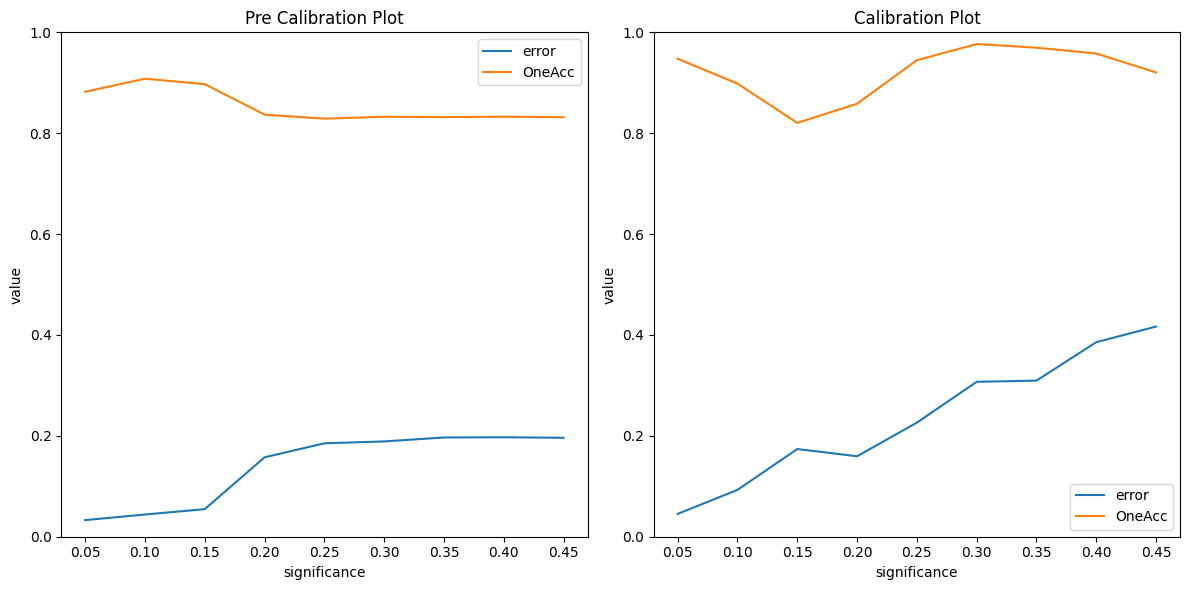

In [2]:
from DT_sampler import DT_sampler
import numpy as np
import pandas as pd
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split

cnf_path = "./cnf/fluorescence_7_seed_42_threshold80.cnf"


# Run DT-sampler and return 50 samples (trees)
dt_sampler = DT_sampler(X_tr, y_tr, 7, threshold=80, cnf_path=cnf_path)
dt_sampler.run(50, method="unigen", sample_seed=0)

# Returns a 3D array containing probabilities of two classes for all 50 trees.
pred_all = dt_sampler.predict_proba_all_trees(X)
pred_all_tree = dt_sampler.predict_proba_ensemble(X)

errors, accs = calibrate_scores(pred_all, labels, alphas, n_calib=200, MARGIN=True, n_run=5)
errors_tree, accs_tree = calibrate_scores(pred_all_tree, labels, alphas, n_calib=200, MARGIN=True, n_run=5)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(alphas, errors, label="error")
ax1.plot(alphas, accs, label="OneAcc")
ax1.set_xlabel("significance")
ax1.set_ylabel("value")
ax1.legend()
ax1.set_title("Pre Calibration Plot")
ax1.set_ylim([0, 1])

ax2.plot(alphas, errors_tree, label="error")
ax2.plot(alphas, accs_tree, label="OneAcc")
ax2.set_xlabel("significance")
ax2.set_ylabel("value")
ax2.legend()
ax2.set_title("Calibration Plot")
ax2.set_ylim([0, 1])

plt.tight_layout()
plt.show()